O objetivo desse dataset é determinar se os cogumelos pertencentes a essa familia são comestiveis ou venenosos a partir de suas caracteristicas.

Esse dataset possui 23 especies diferentes pertencentes a mesma familia.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns # data visualization: graphics
import matplotlib.pyplot as plt # data visualization: graphics
from sklearn.model_selection import train_test_split # split dataset into train/test
from sklearn import preprocessing # pass nominal to number
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.model_selection import KFold # cross validation
from sklearn import metrics # accuracy of model

In [3]:
# carregando dataset
# disponivel em: https://www.kaggle.com/uciml/mushroom-classification
mr = pd.read_csv("mushrooms.csv")

# > ANALISANDO O DATASET

In [4]:
mr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

Tam total do dataset: 8124
quantidade de cogumelos comestiveis: 4208
quantidade de cogumelos venenosos: 3916


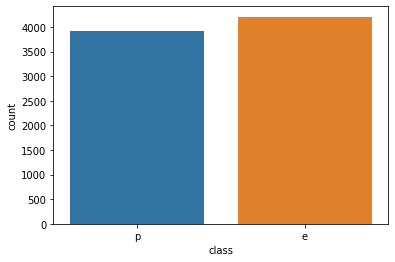

In [5]:
# A primeira coluna representa a classe dos cogumelos.
# 'p' indica que é venenoso, 'e' que é comestivel
sns.countplot(x='class', data=mr)

t = mr.shape[0]
p = mr.loc[mr['class'] == 'p'].shape[0]
e = mr.loc[mr['class'] == 'e'].shape[0]
print("Tam total do dataset: {0}".format(t))
print("quantidade de cogumelos comestiveis: {0}".format(e))
print("quantidade de cogumelos venenosos: {0}".format(p))

## >> Analisando colunas sem valor

In [6]:
# O caractere '?' marca valores nao inseridos.
# Estou analisando as colunas que possuem valores desconhecidos.
columns = list(mr.columns)
for column in columns:
  count = mr.loc[mr[column] == '?'].shape[0]
  print(count)

0
0
0
0
0
0
0
0
0
0
0
2480
0
0
0
0
0
0
0
0
0
0
0


In [7]:
# Somente a coluna 'stalk-root possui valores nao definidos.
# Estou verificando o impacto dela no dataset.
edible = mr.loc[mr['class'] == 'e'].shape[0]
poisonous = mr.loc[mr['class'] == 'p'].shape[0]

edible_empty_value = mr.loc[(mr['stalk-root'] == '?') & (mr['class'] == 'e')].shape[0]
poisonous_empty_value = mr.loc[(mr['stalk-root'] == '?') & (mr['class'] == 'p')].shape[0]

print("Cogumelos comestiveis com dados faltando: {0}".format(edible_empty_value))
print("Cogumelos venenosos com dados faltando: {0}".format(poisonous_empty_value))

print("\n>Impacto final na base de dados:")
value = edible - edible_empty_value
percent = '{0:.2f}'.format(((value/edible)*100))
print("  Cogumelos comestiveis apos remocao: {0}".format(value))
print("  Porcentagem em comparacao ao total: {0}%".format(percent))

value = poisonous - poisonous_empty_value
percent = '{0:.2f}'.format(((value/poisonous)*100))
print("\n  Cogumelos venenosos apos remocao: {0}".format(value))
print("  Porcentagem em comparacao ao total: {0}%".format(percent))

Cogumelos comestiveis com dados faltando: 720
Cogumelos venenosos com dados faltando: 1760

>Impacto final na base de dados:
  Cogumelos comestiveis apos remocao: 3488
  Porcentagem em comparacao ao total: 82.89%

  Cogumelos venenosos apos remocao: 2156
  Porcentagem em comparacao ao total: 55.06%


Existem três possibilidades validas:


*   Trabalhar com a base de dados mesmo tendo dados faltando
*   Preencher com a mediana
*   Apagar os registros que possuem dados faltando
*   Apagar os atributos que possuem dados faltando

Como possuimos muitos dados, podemos nos dar ao luxo de apagar alguns, então não
vou seguir o primeiro caminho;

Como os 2480 valores concetram-se em uma coluna, isso equivale a quase 1/3 do
dataset, preencher com a mediana seria danoso;

Como mostrado no exemplo a cima, a classe mais prejudicada se apagarmos os
registros é a das venenosas, e ela natualmente já possui menos registros que
a classe comestivel, então também não vou seguir esse caminho;

Como possuimos 22 atributos e todos 2480 dados não inseridos concentram-se no
'stalk-root', vou optar por apagar essa coluna.



# Limpando o dataset

In [8]:
import random

all_e = 4208
all_p = 3916
dif = all_e - all_p

mr.drop(['stalk-root'], axis=1, inplace=True) # drop column 'stalk-root'

all_e_index = mr.index[mr['class'] == 'e'].tolist()
random_indexs =random.sample(all_e_index, dif)
mr.drop(random_indexs, axis=0, inplace=True) # drop 292 edible rows

Tam total do dataset: 7832
quantidade de cogumelos comestiveis: 3916
quantidade de cogumelos venenosos: 3916


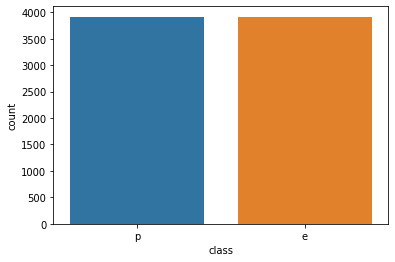

In [9]:
# Verificando os dados limpos
sns.countplot(x='class', data=mr)

t = mr.shape[0]
p = mr.loc[mr['class'] == 'p'].shape[0]
e = mr.loc[mr['class'] == 'e'].shape[0]
print("Tam total do dataset: {0}".format(t))
print("quantidade de cogumelos comestiveis: {0}".format(e))
print("quantidade de cogumelos venenosos: {0}".format(p))

# Tranformando dados nominais em dados numéricos

In [10]:
# Convertendo os dados nominais em dados numericos
le = preprocessing.LabelEncoder()

mr_encode = pd.DataFrame()

for column in mr:
  column_values_encode = le.fit_transform(mr[column])
  mr_encode[column] = column_values_encode

In [11]:
# Vizualizacao do resultado
mr_encode.head(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
5,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1
6,0,0,2,8,1,0,1,0,0,2,...,2,7,7,0,2,1,4,2,2,3
7,0,0,3,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,3,3
8,1,5,3,8,1,6,1,0,1,7,...,2,7,7,0,2,1,4,2,4,1
9,0,0,2,9,1,0,1,0,0,2,...,2,7,7,0,2,1,4,2,3,3


# KNN

In [17]:
# Dividindo dataset em treino(70%) e teste(30%)
train, test = train_test_split(mr_encode, test_size = 0.3)
print(train.shape)
print(test.shape)

(5482, 22)
(2350, 22)


In [18]:
# Separando as classes(Y) dos atributos(X)
# Lembrando que a primeira coluna eh a classe
train_x = train[list(mr_encode.columns.values)[1:]]
train_y = train[list(mr_encode.columns.values)[0]]
test_x = test[list(mr_encode.columns.values)[1:]]
test_y = test[list(mr_encode.columns.values)[0]]

[1.0, 0.9991489361702127, 0.9987234042553191, 0.9991489361702127, 0.9982978723404256, 0.9965957446808511, 0.9953191489361702, 0.9953191489361702, 0.9953191489361702, 0.9906382978723405, 0.9902127659574468, 0.9885106382978723, 0.9885106382978723, 0.9872340425531915, 0.9880851063829788, 0.9868085106382979, 0.987659574468085, 0.9863829787234043, 0.9859574468085106, 0.9825531914893617, 0.9829787234042553]


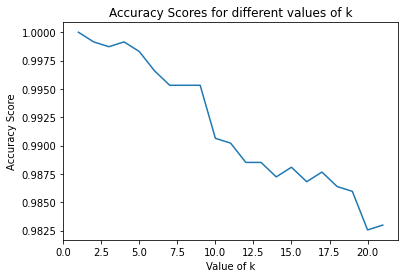

In [19]:
# Testando o melhor valor para K-value
k_range = range(1,22)
scores = []

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(train_x, train_y)
  y_pred = knn.predict(test_x)
  scores.append(metrics.accuracy_score(test_y, y_pred))

print(scores)
plt.plot(list(k_range), scores)
plt.xlabel('Value of k')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for different values of k')
plt.show()

A precisão fica em torno de 100% e 98%, depende muito do sorteio da base de treinamento


In [20]:
# Pegando o maior score para usar seu K-value
max_score = -1
k_max_score = -1
for k in k_range:
  if scores[k-1] > max_score:
    max_score = scores[k-1]
    k_max_score = k
  
print(max_score)
print(k_max_score)

1.0
1


In [21]:
knn = KNeighborsClassifier(n_neighbors=k_max_score)
knn.fit(train_x, train_y)
y_pred = knn.predict(test_x)
precision = metrics.accuracy_score(test_y, y_pred)*100
print('A acurácia do KNN é {0:.2f}%'.format(precision))


A acurácia do KNN é 100.00%
